Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (20.4 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123594 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Mounted at /content/drive
Successfully read and filtered file: /content/extracted_data/(20240801~20240811)_03_11_08_P_│≤╛ε├╠╣╬╣┌╛≈.csv
Successfully read and filtered file: /content/extracted_data/(20240801~20240811)_01_02_0

<ipython-input-1-b307dd6abd64>:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop_duplicates(inplace=True)


NameError: name 'fontprop' is not defined

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44428 (\N{HANGUL SYLLABLE GWEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49437 (\N{HANGUL SYLLABLE SEOG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 53469 (\N{HANGUL SYLLABLE TAEG}) missing from current font.
  fu

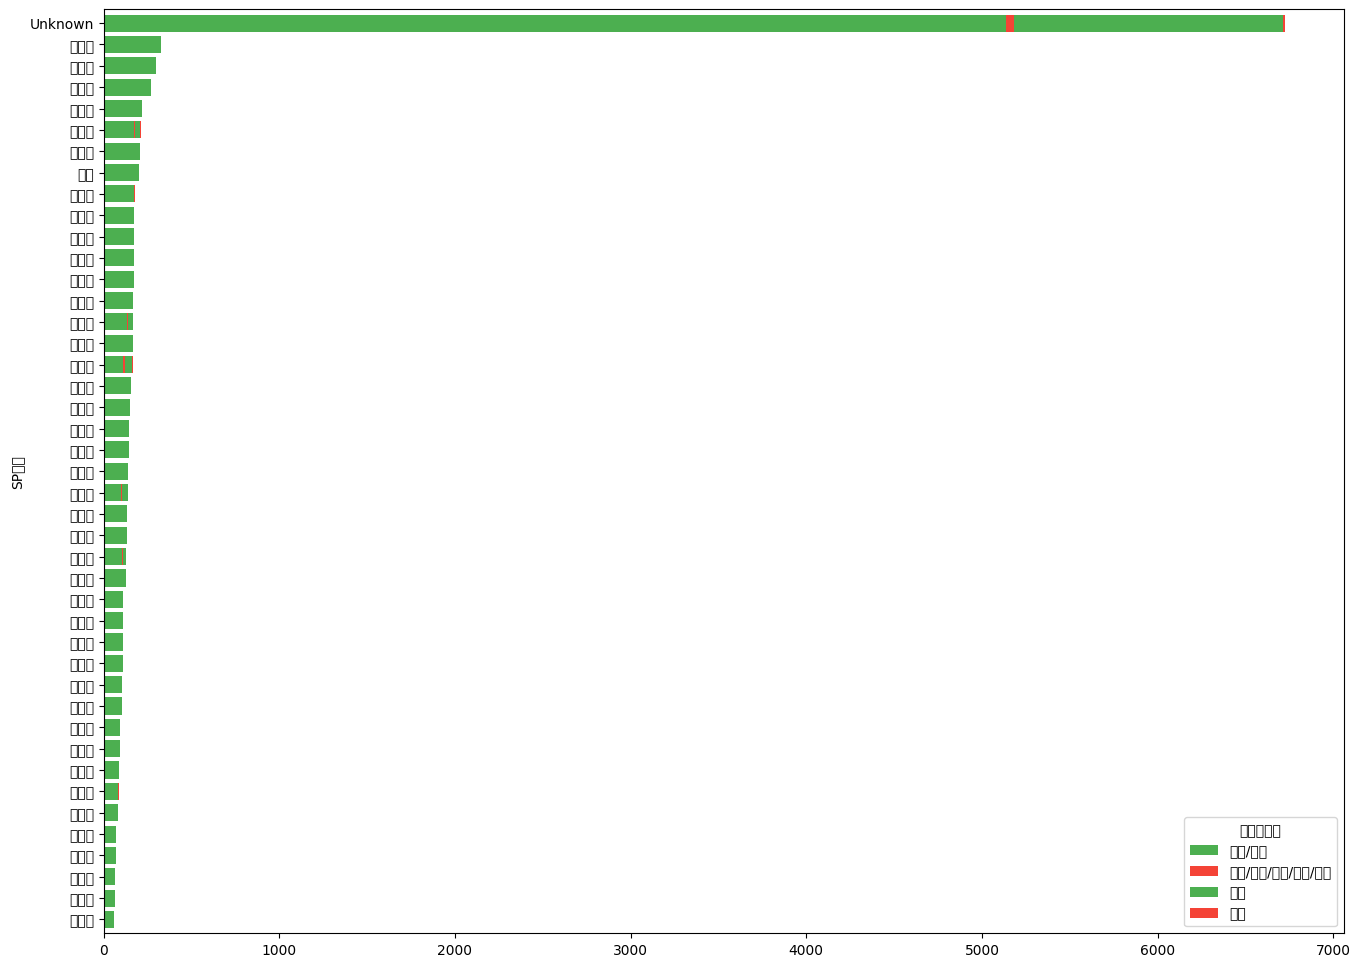

In [1]:
import pandas as pd
import os
import glob
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill, Font
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.backends.backend_pdf import PdfPages

# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 구글 드라이브를 마운트합니다.
drive.mount('/content/drive', force_remount=True)

# 압축 파일 경로 및 압축 해제 경로 설정
zip_file_path = '/content/drive/My Drive/회사업무/인허가_0815/LOCALDATA_NOWMON_CSV 4.zip'
extract_folder = '/content/extracted_data'

# 폴더가 없으면 생성
os.makedirs(extract_folder, exist_ok=True)

# 압축 해제
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
except FileNotFoundError:
    print(f"Error: Specified zip file '{zip_file_path}' not found. Please check the path.")
    exit(1)

# 압축 해제된 폴더에서 모든 CSV 파일 목록 가져오기
all_files = glob.glob(os.path.join(extract_folder, "**/*.csv"), recursive=True)

if len(all_files) == 0:
    print("Warning: No CSV files found in the specified directory. Proceeding with an empty DataFrame.")
    dfs = []  # 빈 리스트로 초기화
else:
    # 각 파일을 읽어서 하나의 DataFrame으로 병합
    dfs = []
    for file in all_files:
        try:
            df = pd.read_csv(file, encoding='cp949', on_bad_lines='skip', dtype=str, low_memory=False)
            # 주소라는 키워드를 포함한 열 확인
            address_columns = [col for col in df.columns if '주소' in col]
            if not address_columns:
                print(f"No address column found in file: {file}")
                continue
            # '서울', '경기', '강원'이 포함된 행 필터링
            df_filtered = df[df[address_columns[0]].str.contains('서울|경기|강원', na=False)]
            dfs.append(df_filtered)
            print(f"Successfully read and filtered file: {file}")
        except Exception as e:
            print(f"Error reading file {file}: {e}")

if len(dfs) == 0:
    concatenated_df = pd.DataFrame()  # 이전 단계에서 파일이 없을 경우 빈 DataFrame 생성
else:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    # 중복된 행 제거: 사업장명, 소재지전체주소, 영업상태명이 동일한 경우 하나만 남기고 제거
    concatenated_df.drop_duplicates(subset=['사업장명', '소재지전체주소', '영업상태명'], inplace=True)

    # '인허가일자' 기준으로 내림차순 정렬
    if '인허가일자' in concatenated_df.columns:
        concatenated_df['인허가일자'] = pd.to_datetime(concatenated_df['인허가일자'], format='%Y%m%d', errors='coerce')
        concatenated_df.sort_values(by='인허가일자', ascending=False, inplace=True)

# 필요한 열만 선택하여 필터링
selected_columns = ['소재지전체주소', '도로명전체주소', '도로명우편번호', '사업장명', '개방서비스명', '인허가일자', '인허가취소', '영업상태명', '폐업일자',
                    '휴업시작일', '휴업종료일', '재개업일자', '소재지전화', '최종수정시점', '업태구분명', '좌표정보(X)', '좌표정보(Y)', '총면적', '소재지면적']

# 존재하는 열만 선택
existing_columns = [col for col in selected_columns if col in concatenated_df.columns]
filtered_df = concatenated_df[existing_columns]

# CSV 파일로 저장
output_dir = '/content/drive/My Drive/회사업무/인허가_0815'
os.makedirs(output_dir, exist_ok=True)
output_csv_path = os.path.join(output_dir, '15일까지변동_일일(서울,경기,강원).csv')
filtered_df.to_csv(output_csv_path, index=False, encoding='cp949')

# 엑셀 파일 경로 설정
file1_path = os.path.join('/content/drive/My Drive/회사업무/행안부자료/0801', '1.영업구역별_주소현행화0725.xlsx')
file2_path = output_csv_path  # 이전 단계에서 생성한 파일 사용

# 파일 경로 확인
if not os.path.exists(file1_path):
    raise FileNotFoundError(f"{file1_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")
if not os.path.exists(file2_path):
    raise FileNotFoundError(f"{file2_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 엑셀 파일 읽기
df1 = pd.read_excel(file1_path)
df2 = pd.read_csv(file2_path, encoding='cp949')

# 주소 정규화 함수
def normalize_address(address):
    if pd.isna(address):
        return address
    address = address.strip()
    address = address.replace('강원특별자치도', '강원도')
    address = address.replace('서울특별시', '서울시')
    if '*' in address:
        return None
    return address

# df1의 주소 정규화
df1['full_address'] = df1[['주소시', '주소군구', '주소동']].astype(str).agg(' '.join, axis=1).apply(normalize_address)
df1 = df1.dropna(subset=['full_address'])

# df2의 주소 정규화
df2['소재지전체주소'] = df2['소재지전체주소'].astype(str).apply(normalize_address)
df2['도로명전체주소'] = df2['도로명전체주소'].astype(str).apply(normalize_address)
df2 = df2.dropna(subset=['소재지전체주소', '도로명전체주소'])

# TF-IDF 벡터화
vectorizer = TfidfVectorizer().fit(df1['full_address'])
tfidf_matrix = vectorizer.transform(df1['full_address'])

# 유사한 주소 매핑
def get_best_match(address, tfidf_matrix, vectorizer, choices, threshold=0.7):
    if pd.isna(address):
        return None
    query_vec = vectorizer.transform([address])
    cosine_similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    best_match_index = cosine_similarities.argmax()
    best_match_score = cosine_similarities[best_match_index]
    if best_match_score >= threshold:
        return choices[best_match_index]
    return None

choices = df1['full_address'].tolist()
df2['matched_address_소재지'] = df2['소재지전체주소'].apply(lambda x: get_best_match(x, tfidf_matrix, vectorizer, choices))
df2['matched_address_도로명'] = df2['도로명전체주소'].apply(lambda x: get_best_match(x, tfidf_matrix, vectorizer, choices))

df2['matched_address'] = df2.apply(lambda x: x['matched_address_소재지'] if pd.notna(x['matched_address_소재지']) else x['matched_address_도로명'], axis=1)

# 매핑되지 않은 항목 확인
unmatched = df2[df2['matched_address'].isna()]
print("매핑되지 않은 항목 수:", len(unmatched))

# 평수 계산을 위한 열 존재 확인 및 병합
merge_columns = ['full_address', '관리지사', 'SP담당']
if '총면적' in df1.columns:
    merge_columns.append('총면적')
if '소재지면적' in df1.columns:
    merge_columns.append('소재지면적')

df_merged = df2.merge(df1[merge_columns], left_on='matched_address', right_on='full_address', how='left', suffixes=('', '_df1'))

# 매핑 결과 확인
print("매핑 후 관리지사 및 SP담당이 비어있는 행 수:", df_merged[['관리지사', 'SP담당']].isna().sum())

# 평수 계산 (1평 = 3.305785 m^2)
def calculate_area(row):
    if '소재지면적' in row and pd.notna(row['소재지면적']):
        return round(row['소재지면적'] / 3.305785, 2)

    elif '총면적' in row and pd.notna(row['총면적']):
        return round(row['총면적'] / 3.305785, 2)
    else:
        return None

df_merged['평수'] = df_merged.apply(calculate_area, axis=1)

# 불필요한 열 제외하고 필요한 열만 선택
columns_to_keep = ['관리지사', 'SP담당', '사업장명', '개방서비스명', '업태구분명', '평수', '소재지전체주소', '도로명전체주소', '소재지전화', '폐업일자', '재개업일자', '영업상태명']
df_filtered = df_merged[columns_to_keep]

# 중복된 항목 제거
df_filtered.drop_duplicates(inplace=True)

# 평수 내림차순 정렬
df_filtered_sorted = df_filtered.sort_values(by='평수', ascending=False)

# NaN 값 처리
df_filtered_sorted['관리지사'] = df_filtered_sorted['관리지사'].fillna('Unknown')
df_filtered_sorted['SP담당'] = df_filtered_sorted['SP담당'].fillna('Unknown')

# 네이버 지도 하이퍼링크 생성 함수
def create_naver_map_link(address):
    return f"https://map.naver.com/v5/search/{address}"

# 엑셀 파일에 네이버 지도 링크 추가하는 함수
def add_naver_map_links(ws, address_col_idx):
    ws.insert_cols(1)  # 첫 번째 열에 열 추가
    ws.cell(row=1, column=1, value="네이버 지도 링크")  # 새 열에 헤더 추가

    for row in range(2, ws.max_row + 1):
        address = ws.cell(row=row, column=address_col_idx + 1).value
        if address:
            link = create_naver_map_link(address)
            ws.cell(row=row, column=1).hyperlink = link
            ws.cell(row=row, column=1).value = "네이버 지도 보기"
            ws.cell(row=row, column=1).style = "Hyperlink"

# 엑셀 파일에 데이터를 저장하고 스타일을 설정하는 함수
def save_to_excel(df, file_path):
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        # 전체 시트 저장
        df.to_excel(writer, index=False, sheet_name='전체')

        # 영업/정상 시트 저장
        df_active = df[df['영업상태명'].isin(['영업/정상'])]
        df_active.to_excel(writer, index=False, sheet_name='영업_정상')

        # 폐업 시트 저장
        df_closed = df[df['영업상태명'] == '폐업']
        df_closed.to_excel(writer, index=False, sheet_name='폐업')

        workbook = writer.book
        thin_border = Border(left=Side(style='thin', color='D3D3D3'),
                             right=Side(style='thin', color='D3D3D3'),
                             top=Side(style='thin', color='D3D3D3'),
                             bottom=Side(style='thin', color='D3D3D3'))
        header_fill = PatternFill(start_color="000080", end_color="000080", fill_type="solid")
        header_font = Font(color="FFFFFF", bold=True)

        # 스타일 설정 함수
        def set_style(worksheet):
            for cell in worksheet[1]:
                cell.fill = header_fill
                cell.font = header_font
                cell.border = thin_border
                cell.alignment = Alignment(horizontal='center', vertical='center')
            for row in worksheet.iter_rows(min_row=2):
                for cell in row:
                    cell.border = thin_border
                    cell.alignment = Alignment(horizontal='center', vertical='center')
            for col in worksheet.columns:
                max_length = 0
                column = col[0].column_letter
                for cell in col:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(cell.value)
                    except:
                        pass
                adjusted_width = (max_length + 2)
                worksheet.column_dimensions[column].width = adjusted_width

        set_style(writer.sheets['전체'])
        set_style(writer.sheets['영업_정상'])
        set_style(writer.sheets['폐업'])

        # 네이버 지도 링크 추가
        # '소재지전체주소'는 H열이므로 컬럼 인덱스는 8-1=7
        add_naver_map_links(writer.sheets['전체'], 7)
        add_naver_map_links(writer.sheets['영업_정상'], 7)
        add_naver_map_links(writer.sheets['폐업'], 7)

# 전체 데이터를 바탕으로 시각화 및 파일 저장
output_dir = '/content/drive/My Drive/회사업무/인허가_0815'
for manager in df_filtered_sorted['관리지사'].unique():
    manager_dir = os.path.join(output_dir, manager)
    os.makedirs(manager_dir, exist_ok=True)
    df_manager = df_filtered_sorted[df_filtered_sorted['관리지사'] == manager]

    for sp in df_manager['SP담당'].unique():
        df_sp = df_manager[df_manager['SP담당'] == sp]
        sp_file_path = os.path.join(manager_dir, f'{manager}_{sp}_0815까지.xlsx')
        save_to_excel(df_sp, sp_file_path)

# 전체 데이터를 저장
total_file_path = os.path.join(output_dir, '15일_일일_전체_최종결과물.xlsx')
save_to_excel(df_filtered_sorted, total_file_path)


# 전체 데이터를 바탕으로 시각화
status_counts = df_filtered_sorted.groupby(['SP담당', '영업상태명']).size().unstack(fill_value=0)
status_counts = status_counts.loc[status_counts.sum(axis=1).sort_values(ascending=True).index]

# 시각화 (가로 막대 그래프)
fig, ax = plt.subplots(figsize=(16, 12))
colors = ['#4caf50', '#f44336']  # 영업/정상 = 녹색, 폐업 = 빨간색

# 막대 그래프 생성
bars = status_counts.plot(kind='barh', stacked=True, ax=ax, color=colors, width=0.8)

# 그래프 제목 및 레이블 설정
ax.set_title('SP담당별 영업상태명 집계현황', fontsize=18, fontproperties=fontprop, fontweight='bold')
ax.set_xlabel('건수', fontsize=14, fontproperties=fontprop, fontweight='bold')
ax.set_ylabel('SP담당', fontsize=14, fontproperties=fontprop, fontweight='bold')
plt.xticks(fontsize=12, fontproperties=fontprop)
plt.yticks(fontsize=12, fontproperties=fontprop)

# 막대에 숫자 표시
for container in bars.containers:
    bars.bar_label(container, label_type='center', fontsize=10, fontproperties=fontprop, color='white' if container.get_label() == '영업/정상' else 'black')

# 범례 설정
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, title='영업상태명', fontsize=12, title_fontsize='14', prop=fontprop, loc='lower right')
plt.setp(legend.get_title(), fontproperties=fontprop)

# 그래프에 그리드 추가
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# 그래프를 이미지로 저장
fig_path = os.path.join(output_dir, '전체_영업상태명_집계현황_전문가_0814.png')
fig.savefig(fig_path, bbox_inches='tight')

# 그래프를 출력
plt.show()

print(f"전체 영업상태명 집계현황 전문가 그래프가 생성되었습니다: {fig_path}")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.font_manager as fm

# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
!fc-cache -fv

# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 설정

# 구글 드라이브를 마운트합니다.
drive.mount('/content/drive', force_remount=True)

# 정확한 파일 경로 입력
file_path = '/content/drive/My Drive/회사업무/인허가_0815/15일_일일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df_filtered_sorted = pd.read_excel(file_path)

# '중앙' 지사 및 'Unknown' 제외
df_filtered_sorted = df_filtered_sorted[(df_filtered_sorted['관리지사'] != 'Unknown') &
                                        (df_filtered_sorted['SP담당'] != 'Unknown')]

# '영업/정상'과 '폐업' 상태만 필터링
df_filtered_sorted = df_filtered_sorted[df_filtered_sorted['영업상태명'].isin(['영업/정상', '폐업'])]

# 매핑된 데이터만 필터링
df_filtered_sorted = df_filtered_sorted.dropna(subset=['관리지사', 'SP담당'])

# 관리지사별로 집계
grouped_df = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)

# 원하는 순서로 관리지사 정렬
desired_order = ['중앙지사', '강북지사', '서대문지사', '고양지사', '의정부지사', '남양주지사', '원주지사', '강릉지사']
grouped_df = grouped_df.reindex(desired_order)

# 관리지사별 현황표 생성
print("관리지사별 영업상태 현황표:")
print(grouped_df)

# 시각화 (막대 그래프)
fig, ax = plt.subplots(figsize=(20, 14))  # 그래프 크기를 크게 조정
colors = ['#4caf50', '#f44336']  # 영업/정상 = 녹색, 폐업 = 빨간색

# 막대 그래프 생성
bars = grouped_df.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.8)

# 그래프 제목 및 레이블 설정
ax.set_title('관리지사별 영업상태명 집계현황', fontsize=22, fontproperties=fontprop)
ax.set_xlabel('관리지사', fontsize=16, fontproperties=fontprop)
ax.set_ylabel('건수', fontsize=16, fontproperties=fontprop)
plt.xticks(fontsize=14, fontproperties=fontprop, rotation=0, ha='center')  # 텍스트 수평 정렬
plt.yticks(fontsize=14, fontproperties=fontprop)

# 막대에 숫자 표시
for container in bars.containers:
    bars.bar_label(container, label_type='center', fontsize=12, fontproperties=fontprop, color='white' if container.get_label() == '영업/정상' else 'black')

# 범례 설정
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, title='영업상태명', fontsize=12, title_fontsize='14', prop=fontprop, loc='upper right', frameon=True)
plt.setp(legend.get_title(), fontproperties=fontprop)

# 범례 배경과 테두리 설정
legend.get_frame().set_facecolor('white')  # 배경색
legend.get_frame().set_edgecolor('black')  # 테두리색

# 그래프에 그리드 추가
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# 그래프를 이미지로 저장
output_dir = '/content/drive/My Drive/회사업무/인허가_0814'
fig_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.png')
fig.savefig(fig_path, bbox_inches='tight')

# 그래프를 출력
plt.show()

print(f"관리지사별 영업상태명 집계현황 그래프가 생성되었습니다: {fig_path}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

ValueError: mount failed

In [7]:
from google.colab import drive
drive.flush_and_unmount()  # 현재 마운트된 드라이브 해제
drive.mount('/content/drive', force_remount=True)  # 다시 마운트

ValueError: flush_and_unmount failed